# Linear Algebra - Extra curriculum

<div style="display:none;">Dive into the fundamentals of linear algebra for machine learning and data science. This week you'll apply linear algebra to PCA (Principal Component Analysis) and SVM (Support Vector Machines).</div>

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8-whitegrid")

## Principal Componenent Analysis

Let's apply all the learnings in this notebook to a simple example of PCA.

We'll see applications of:
- singular and non-singular matrices
- determinants
- dot products
- linear transformations
- eigenvectors and eigenvalues
- vector projections

This was inspired by Luis Serrano's [YT video](https://www.youtube.com/watch?v=g-Hb26agBFg) on PCA.

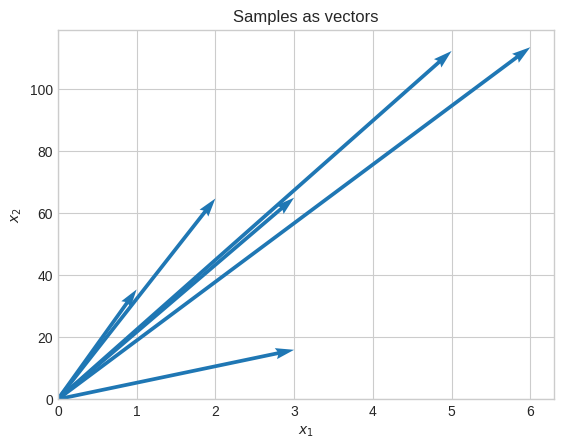

In [2]:
rng = np.random.default_rng(1)

x1 = np.array([[1], [2], [3], [3], [5], [6]])
x2 = (
    10
    + np.array([[1], [2], [3], [3], [5], [6]]) * 15
    + rng.normal(0.0, 30.0, 6).reshape(-1, 1)
)
X = np.hstack([x1, x2])

for r in range(X.shape[0]):
    plt.quiver(
        [0],
        [0],
        [X[r][0]],
        [X[r][1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="tab:blue",
    )
plt.xlim(0, X[:, 0].max() * 1.05)
plt.ylim(0, X[:, 1].max() * 1.05)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Samples as vectors")
plt.show()

Let's standardize the data.

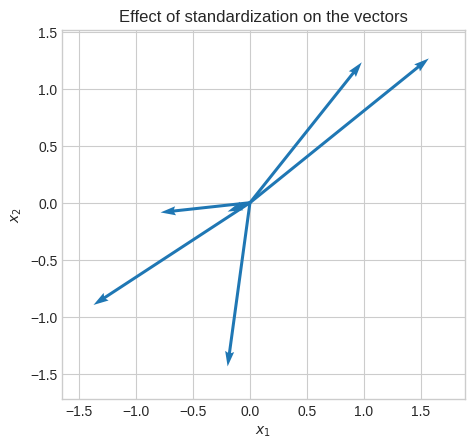

In [3]:
Z = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
for r in range(Z.shape[0]):
    plt.quiver(
        [0],
        [0],
        [Z[r][0]],
        [Z[r][1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="tab:blue",
    )
plt.xlim(Z[:, 0].min() * 1.2, Z[:, 0].max() * 1.2)
plt.ylim(Z[:, 1].min() * 1.2, Z[:, 1].max() * 1.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")
plt.title("Effect of standardization on the vectors")
plt.show()

Let's calculate the covariance matrix, whose eigenvectors represent the directions of the maximum variance (or better maximum correlation since we're using standardized data).

In [4]:
cov = np.cov(Z[:, 0], Z[:, 1], bias=True)
cov_evecs = np.linalg.eig(cov)[1]
cov_v1 = cov_evecs[:, 0]
cov_v2 = cov_evecs[:, 1]
print(f"Determinant of transformation: {np.linalg.det(cov):.2f}")
print(f"Dot product of eigenvectors: {np.dot(cov_v1, cov_v2):.2f}")

Determinant of transformation: 0.36
Dot product of eigenvectors: 0.00


We can see that the covariance matrix represent a non-singular linear transformation.

We can also see that the eigenvectors are orthogonal because their dot product is 0.

> 🔑 The eigenvectors of a symmetric matrix are orthogonal

Another property of symmetric matrices is that their transformation always entails some sort of stretching, which means that the eigenvalues are always real numbers (not complex numbers like in the case of rotations).

Let's visualize the effect of the linear transformation induced by the covariance matrix.

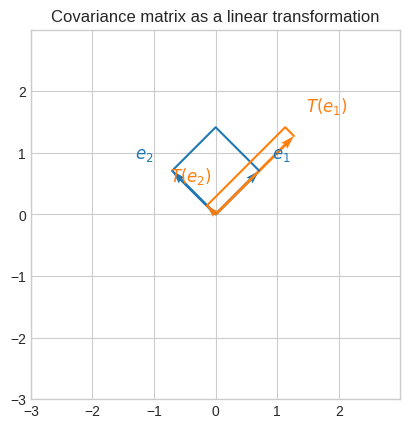

In [5]:
def plot_transformation(T, title, ax, basis=None, lim=5):
    if basis is None:
        e1 = np.array([[1], [0]])
        e2 = np.array([[0], [1]])
    else:
        e1, e2 = basis
    zero = np.zeros(1, dtype="int")
    c = "tab:blue"
    c_t = "tab:orange"
    ax.set_xticks(np.arange(-lim, lim))
    ax.set_yticks(np.arange(-lim, lim))
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    _plot_vectors(e1, e2, c, ax)
    ax.plot(
        [zero, e2[0], e1[0] + e2[0], e1[0]],
        [zero, e2[1], e1[1] + e2[1], e1[1]],
        color=c,
    )
    _make_labels(e1, "$e_1$", c, y_offset=(-0.2, 1.0), ax=ax)
    _make_labels(e2, "$e_2$", c, y_offset=(-0.2, 1.0), ax=ax)
    e1_t = T(e1)
    e2_t = T(e2)
    _plot_vectors(e1_t, e2_t, c_t, ax)
    ax.plot(
        [zero, e2_t[0], e1_t[0] + e2_t[0], e1_t[0]],
        [zero, e2_t[1], e1_t[1] + e2_t[1], e1_t[1]],
        color=c_t,
    )
    _make_labels(e1_t, "$T(e_1)$", c_t, y_offset=(0.0, 1.0), ax=ax)
    _make_labels(e2_t, "$T(e_2)$", c_t, y_offset=(0.0, 1.0), ax=ax)
    ax.set_aspect("equal")
    ax.set_title(title)


def _make_labels(e, text, color, y_offset, ax):
    e_sgn = 0.4 * np.array([[1] if i == 0 else i for i in np.sign(e)])
    return ax.text(
        e[0] - 0.2 + e_sgn[0],
        e[1] + y_offset[0] + y_offset[1] * e_sgn[1],
        text,
        fontsize=12,
        color=color,
    )


def _plot_vectors(e1, e2, color, ax):
    ax.quiver(
        [0, 0],
        [0, 0],
        [e1[0], e2[0]],
        [e1[1], e2[1]],
        color=color,
        angles="xy",
        scale_units="xy",
        scale=1,
    )


def T(A, v):
    w = A @ v
    return w


fig, ax = plt.subplots()
plot_transformation(
    partial(T, cov),
    title="Covariance matrix as a linear transformation",
    basis=(cov_v1.reshape(-1, 1), cov_v2.reshape(-1, 1)),
    ax=ax,
    lim=3,
)

To better see the effect of the transformation, we've used a basis that its parallel to the eigenbasis of the transformation.

$COV_{x_1x_2} = \begin{bmatrix}1&&0.8\\0.8&&1\end{bmatrix}$

$\vec{v_1} = \begin{bmatrix}0.7\\0.7\end{bmatrix}$

$\vec{v_2} = \begin{bmatrix}-0.7\\0.7\end{bmatrix}$

$COV_{x_1x_2} \cdot \vec{v_1} = \begin{bmatrix}1 \times 0.7 + 0.8 \times 0.7\\0.8 \times 0.7 + 1 \times 0.7\end{bmatrix} = \begin{bmatrix}1.3\\1.3\end{bmatrix}$

$COV_{x_1x_2} \cdot \vec{v_2} = \begin{bmatrix}1 \times -0.7 + 0.8 \times 0.7\\0.8 \times -0.7 + 1 \times 0.7\end{bmatrix} = \begin{bmatrix}-0.14\\0.14\end{bmatrix}$

Let's overlay the eigenvectors on the data.

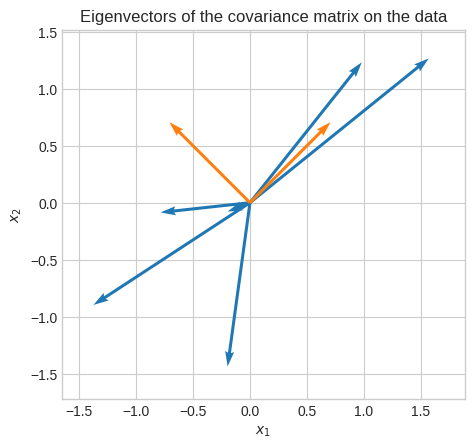

In [6]:
for r in range(Z.shape[0]):
    plt.quiver(
        [0],
        [0],
        [Z[r][0]],
        [Z[r][1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="tab:blue",
    )
plt.quiver(
    [0, 0],
    [0, 0],
    [cov_v1[0], cov_v2[0]],
    [cov_v1[1], cov_v2[1]],
    angles="xy",
    scale=1,
    scale_units="xy",
    color="tab:orange",
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(Z[:, 0].min() * 1.2, Z[:, 0].max() * 1.2)
plt.ylim(Z[:, 1].min() * 1.2, Z[:, 1].max() * 1.2)
plt.gca().set_aspect("equal")
plt.title("Eigenvectors of the covariance matrix on the data")
plt.show()

Let's see the principal components (eigenvectors times eigenvalues). Of course, the first principal component is the one with the highest magnitude (eigenvalue).

Given the nature of this data (positively correlated) we expect the first principal component to be the one corresponding to the eigenvector with signs [+, +] or [-, -].

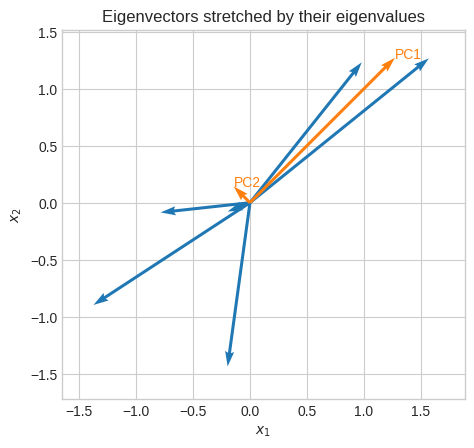

In [7]:
eigvls, eigvcs = np.linalg.eig(cov)
rank = np.argsort(-eigvls)
eigvls = eigvls[rank]
eigvcs = eigvcs[:, rank]
pc = eigvcs * eigvls

for r in range(Z.shape[0]):
    plt.quiver(
        [0],
        [0],
        [Z[r][0]],
        [Z[r][1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="tab:blue",
    )
plt.quiver(
    [0, 0],
    [0, 0],
    [pc[:, 0][0], pc[:, 1][0]],
    [pc[:, 0][1], pc[:, 1][1]],
    angles="xy",
    scale=1,
    scale_units="xy",
    color="tab:orange",
)
plt.annotate("PC1", pc[:, 0], color="tab:orange")
plt.annotate("PC2", pc[:, 1], color="tab:orange")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(Z[:, 0].min() * 1.2, Z[:, 0].max() * 1.2)
plt.ylim(Z[:, 1].min() * 1.2, Z[:, 1].max() * 1.2)
plt.gca().set_aspect("equal")
plt.title("Eigenvectors stretched by their eigenvalues")
plt.show()

Let's project all the vectors onto the first principal component.

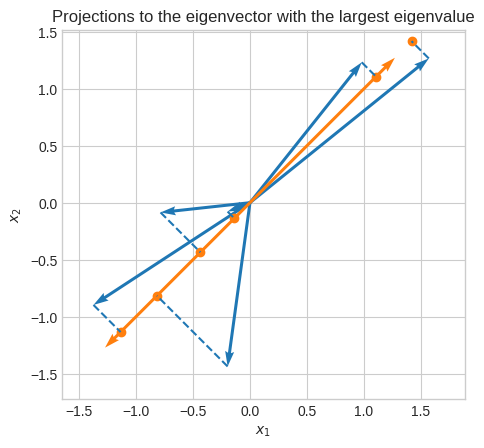

In [8]:
n_components = 1
proj_norm = np.dot(Z, eigvcs[:, :n_components])  # (6, 2) @ (2, 1) -> (6, 1)
proj = np.dot(proj_norm, eigvcs[:, :n_components].T)  # (6, 1) @ (1, 2) -> (6, 2)
plt.plot([Z[:, 0], proj[:, 0]], [Z[:, 1], proj[:, 1]], "--", color="tab:blue")
for r in range(Z.shape[0]):
    plt.quiver(
        [0],
        [0],
        [Z[r][0]],
        [Z[r][1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="tab:blue",
    )
plt.quiver(
    [0, 0],
    [0, 0],
    [pc[:, 0][0], -pc[:, 0][0]],
    [pc[:, 0][1], -pc[:, 0][0]],
    angles="xy",
    scale=1,
    scale_units="xy",
    color="tab:orange",
)
plt.scatter(proj[:, 0], proj[:, 1], color="tab:orange")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(Z[:, 0].min() * 1.2, Z[:, 0].max() * 1.2)
plt.ylim(Z[:, 1].min() * 1.2, Z[:, 1].max() * 1.2)
plt.gca().set_aspect("equal")
plt.title("Projections to the eigenvector with the largest eigenvalue")
plt.show()

## Support Vector Machines

Another interesting application to illustrate the importance of linear algebra is SVM.

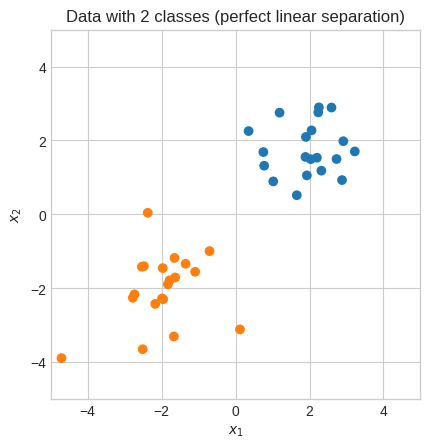

In [9]:
rng = np.random.default_rng(1)
group_1_centroid = [-2, -2]
group_2_centroid = [2, 2]
X = np.r_[
    rng.standard_normal((20, 2)) + group_1_centroid,
    rng.standard_normal((20, 2)) + group_2_centroid,
]
y = np.array([-1] * 20 + [1] * 20)

plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"))
plt.gca().set_aspect("equal")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Data with 2 classes (perfect linear separation)")
plt.show()

We need to find a line $wx+b$ such that

$h(x_i) = \begin{cases}1 &\text{if }wx_i+b \ge 0\\-1 &\text{otherwise }\end{cases} \text{ for } i = 1, \dots, m$

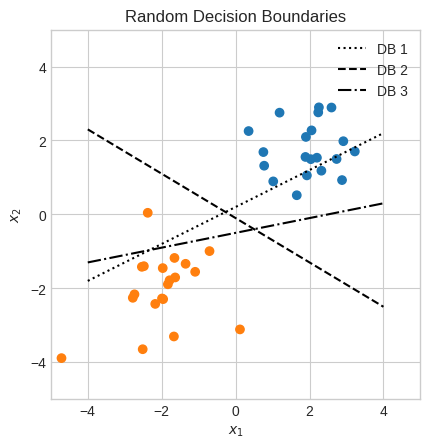

In [10]:
def decision_boundary(x1, b, w):
    return (-w[0] * x1 - b) / w[1]


plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"))
x1 = np.linspace(-4, 4, 100)
plt.plot(
    x1,
    decision_boundary(x1, b=0.2, w=np.array([0.5, -1])),
    color="k",
    linestyle="dotted",
    label="DB 1",
)
plt.plot(
    x1,
    decision_boundary(x1, b=-0.1, w=np.array([-0.6, -1])),
    color="k",
    linestyle="dashed",
    label="DB 2",
)
plt.plot(
    x1,
    decision_boundary(x1, b=-0.5, w=np.array([0.2, -1])),
    color="k",
    linestyle="dashdot",
    label="DB 3",
)
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Random Decision Boundaries")
plt.show()

Intuitively, we know DB 2 ($x_2 = -0.1 - 0.6x_1$) is the best one of the three, but why?

We haven't seen this during the course, but the normalized distance between a point and a line is

> 📐 $d = \cfrac{|w_1x_1 + w_2x_2 + b|}{\sqrt{w_1^2 + w_2^2}} = \cfrac{|w \cdot x + b|}{\|w\|}$

<img src="https://ds055uzetaobb.cloudfront.net/brioche/uploads/pHeSaRZIjr-untitled-drawing-7.png" width="300px">
*Source: www.brilliant.org*

$x_2 = -0.1 - 0.6x_1$ can be rewritten as $-0.6x_1 -1x_2 -0.1 = 0$ so we can get

$d = \cfrac{|-0.6x_1 -1x_2 -0.1|}{\sqrt{-0.6^2 + -1^2}}$

It turns out that the formula for $d$ (distance between a point and a line) has a vector projection proof.

Let the point $P = (x^0_1, x^0_2)$ and let the given line have equation $w_1x_1 + w_2x_2 + b = 0$.  

Also, let $Q = (x^1_1, x^1_2)$  be any point on this line and let the vector $\vec{w} = \langle w_1, w_2 \rangle$ starting at point $Q$.

For example, $Q$ could be $(x_1, -0.1 - 0.6x_1)$, and by arbitrarily fixing $x_1 = 0$ we get $Q = (0, -0.1)$.

The vector $\vec{w}$ is perpendicular to the line.

The distance $d$ from the point $P$ to the line is equal to the length of the orthogonal projection of $\overrightarrow{QP}$ onto $\vec{w}$.

$d = \|\overrightarrow{proj_{w}QP}\| = \cfrac{(\vec{P} - \vec{Q}) \cdot \vec{w}}{\|\vec{w}\|} \cfrac{\vec{w}}{\|\vec{w}\|}$

The only difference to what we saw earlier during the course is that the vector $\vec{P}$ starts at point $Q$ (a point on the line) and not the origin.

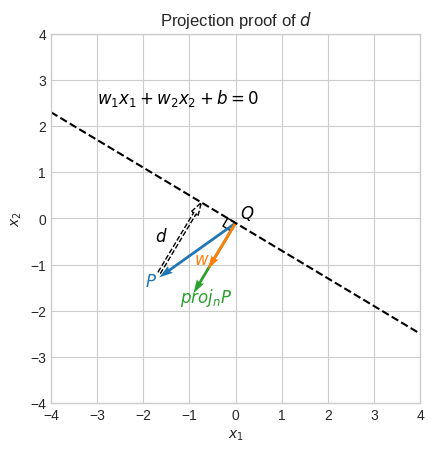

In [11]:
w = np.array([-0.6, -1.0])
P = X[0]
Q = np.array([0, decision_boundary(0, b=-0.1, w=w)])
proj_P = (np.dot(P - Q, w) / np.linalg.norm(w)) * (w / np.linalg.norm(w))

x1 = np.linspace(-4, 4, 100)
plt.plot(
    x1,
    decision_boundary(x1, b=-0.1, w=w),
    color="k",
    linestyle="dashed",
    label="DB 2",
)
arc = plt.Rectangle(
    Q,
    -0.2,
    -0.2,
    angle=np.degrees(np.arctan(w[0])),
    fill=False,
    edgecolor="k",
)
plt.gca().add_patch(arc)
plt.quiver(
    [
        Q[0],
        Q[0],
        P[0],
        Q[0],
    ],
    [
        Q[1],
        Q[1],
        P[1],
        Q[1],
    ],
    [
        P[0],
        proj_P[0],
        -proj_P[0],
        w[0],
    ],
    [
        P[1],
        proj_P[1],
        -proj_P[1],
        w[1],
    ],
    angles="xy",
    scale=1,
    scale_units="xy",
    fc=["tab:blue", "tab:green", "none", "tab:orange"],
    ec=["none", "none", "k", "none"],
    ls=["solid", "solid", "dashed", "solid"],
    linewidth=1,
)
plt.text(X[0, 0] - 0.3, X[0, 1] - 0.3, "$P$", color="tab:blue", fontsize=12)
plt.text(w[0] - 0.3, w[1], "$w$", color="tab:orange", fontsize=12)
plt.text(
    proj_P[0] - 0.3, proj_P[1] - 0.3, "$proj_{n}P$", color="tab:green", fontsize=12
)
plt.text(-3, 2.5, "$w_1x_1 + w_2x_2 + b = 0$", color="k", fontsize=12)
plt.text(-1.75, -0.5, "$d$", color="k", fontsize=12)
plt.text(Q[0] + 0.1, Q[1] + 0.1, "$Q$", color="k", fontsize=12)
plt.title("Projection proof of $d$")
plt.gca().set_aspect("equal")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Let's verify it.

In [12]:
d = np.abs(P @ w.reshape(-1, 1) + -0.1) / np.linalg.norm(w)
proof_d = np.linalg.norm(proj_P)
assert np.isclose(d, proof_d)

The smallest distance among all data points to the decision boundary is called margin.

$\gamma(w, b) = \min\cfrac{|wx_i+b|}{\|w\|}$

In [13]:
def margin(X, b, w):
    return np.min(np.abs(X @ w.reshape(-1, 1) + b) / np.linalg.norm(w))


print(f"Margin of decision boundary 1: {margin(X, b=0.2, w=np.array([0.5, -1])):.2f}")
print(f"Margin of decision boundary 2: {margin(X, b=-0.1, w=np.array([-0.6, -1])):.2f}")
print(f"Margin of decision boundary 3: {margin(X, b=-0.5, w=np.array([0.2, -1])):.2f}")

Margin of decision boundary 1: 0.06
Margin of decision boundary 2: 1.10
Margin of decision boundary 3: 0.34


This confirms our intuition that the DB 2 was the best of the three.

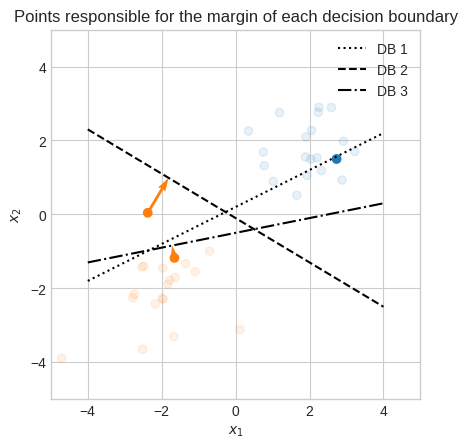

In [14]:
def margin_loc(X, b, w):
    return np.argmin(np.abs(X @ w.reshape(-1, 1) + b) / np.linalg.norm(w))


s1 = margin_loc(X, b=0.2, w=np.array([0.5, -1]))
s2 = margin_loc(X, b=-0.1, w=np.array([-0.6, -1]))
s3 = margin_loc(X, b=-0.5, w=np.array([0.2, -1]))

plt.scatter(
    X[[s1, s2, s3], 0],
    X[[s1, s2, s3], 1],
    c=np.where(y[[s1, s2, s3]] == -1, "tab:orange", "tab:blue"),
)

plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"), alpha=0.1)

x1 = np.linspace(-4, 4, 100)
plt.plot(
    x1,
    decision_boundary(x1, b=0.2, w=np.array([0.5, -1])),
    color="k",
    linestyle="dotted",
    label="DB 1",
)
plt.plot(
    x1,
    decision_boundary(x1, b=-0.1, w=np.array([-0.6, -1])),
    color="k",
    linestyle="dashed",
    label="DB 2",
)
plt.plot(
    x1,
    decision_boundary(x1, b=-0.5, w=np.array([0.2, -1])),
    color="k",
    linestyle="dashdot",
    label="DB 3",
)


def quiver_to_boundary(X, y, b, w, s):
    Q = np.array([0, decision_boundary(0, b=b, w=w)])
    proj = (np.dot(X[s] - Q, w) / np.linalg.norm(w)) * (w / np.linalg.norm(w))
    plt.quiver(
        [X[s][0]],
        [X[s][1]],
        [-proj[0]],
        [-proj[1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color=np.where(y[[s]] == -1, "tab:orange", "tab:blue"),
    )


quiver_to_boundary(X, y, b=0.2, w=np.array([0.5, -1]), s=s1)
quiver_to_boundary(X, y, b=-0.1, w=np.array([-0.6, -1]), s=s2)
quiver_to_boundary(X, y, b=-0.5, w=np.array([0.2, -1]), s=s3)

plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Points responsible for the margin of each decision boundary")
plt.gca().set_aspect("equal")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

The primary objective of SVM is to find a decision boundary that maximizes the margin between two classes. 

But that alone is not sufficient. We also need to ensure that the points lie on the correct side of the boundary.

It becomes a constrained optimization problem.

$\begin{array}{l}
\max \limits_{w, b} \gamma(w, b) \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 0 \text{ } \forall i = 1, \dots, m
\end{array}$

Let's substitute the definition of margin and we get

$\begin{array}{l}
\max \limits_{w, b} \min\cfrac{|wx_i+b|}{\|w\|} \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 0 \text{ } \forall i = 1, \dots, m
\end{array}$

Without a constraint on $w$ and $b$, we would have infinite possible values for these parameters that would give the same separating decision boundary due to its scale invariance.

We can set a scale for $w$ and $b$ by adding the additional constraint $\min|wx_i+b| = 1$.

In other words, the scale of the values of $w$ and $b$ will be such that the smallest distance between the points and the decision boundary is $\cfrac{1}{\|w\|}$.

Why is the constant set to 1 and not another number?

Well, because this allows us to remove it from $\max \limits_{w, b} \min\cfrac{|wx_i+b|}{\|w\|} \Longrightarrow \max \limits_{w, b} \cfrac{1}{\|w\|} \text{ s.t. } \min|wx_i+b| = 1$.

So after putting it all together we have

$\begin{array}{l}
\max \limits_{w, b} \cfrac{1}{\|w\|} \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 0 \\ 
\quad \quad \quad \quad \quad \min|wx_i+b| = 1 \quad \forall i = 1, \dots, m
\end{array}$

We can combine the two constraints into one and obtain

$\begin{array}{l}
\max \limits_{w, b} \cfrac{1}{\|w\|} \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 \quad \forall i = 1, \dots, m
\end{array}$

Furthermore, $\max\cfrac{1}{\|w\|}$ is equivalent to $\min\|w\|$, which in turn is equivalent to $\min \|w\|^2$ which we can rewrite as dot product.

$\begin{array}{l}
\min \limits_{w, b} w \cdot w \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 \quad \forall i = 1, \dots, m
\end{array}$

To simplify the optimization even further we can introduce a factor of $\cfrac{1}{2}$ so that the derivative becomes $w$ instead of $2w$.

$\begin{array}{l}
\min \limits_{w, b} \cfrac{1}{2} w \cdot w \\
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 \quad \forall i = 1, \dots, m
\end{array}$

During the optimization for SVM, we must estimate all 3 parameters: $w_1$, $w_2$ and $b$. 

This may seem counter intuitive given that a line inherently has only 2 degrees of freedom (slope and intercept).

However, the constraint $\min|wx_i+b| = 1$ ensures that only one scale-invariant decision boundary can be selected, making $w_1$, $w_2$ and $b$ uniquely identifiable.


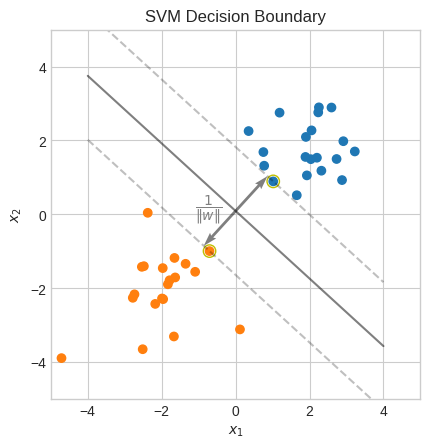

Accuracy: 100%


In [15]:
def hard_loss(params):
    w = params[: X.shape[1]]
    return 0.5 * np.dot(w, w)


def hard_constraint(params, X, y, i):
    w = params[: X.shape[1]]
    b = params[X.shape[1]]
    return y[i] * (np.dot(w, X[i]) + b) - 1


def parallel_thru_point(x1, w, p):
    return p[1] - w[0] * (x1 - p[0]) / w[1]


hard_initial = np.random.uniform(0, 1, 3)
hard_cons = [
    {"type": "ineq", "fun": hard_constraint, "args": (X, y, i)}
    for i in range(X.shape[0])
]

hard_result = minimize(fun=hard_loss, x0=hard_initial, constraints=hard_cons)

if np.allclose(hard_initial, hard_result.x):
    raise ValueError("Initial values close to final estimates")

w = hard_result.x[: X.shape[1]]
b = hard_result.x[X.shape[1]]
sv = X[np.isclose(np.abs(X @ w.reshape(-1, 1) + b), 1.0, atol=1e-6).squeeze()]

# plot data
plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"))
# plot decision boundary
x1 = np.linspace(-4, 4, 100)
plt.plot(x1, (-w[0] * x1 - b) / w[1], color="k", alpha=0.5)
# plot parallels thru support vectors
plt.plot(
    x1, parallel_thru_point(x1, w, sv[0]), color="k", linestyle="dashed", alpha=0.25
)
plt.plot(
    x1, parallel_thru_point(x1, w, sv[1]), color="k", linestyle="dashed", alpha=0.25
)
# highlight support vectors
plt.scatter(
    sv[:, 0],
    sv[:, 1],
    s=80,
    facecolors="none",
    edgecolors="y",
    color="y",
)
# plot margin
Q = np.array([0, decision_boundary(0, b=b, w=w)])
proj_sv = (np.dot(sv[0] - Q, w) / np.linalg.norm(w)) * (w / np.linalg.norm(w))
plt.quiver(
    [Q[0], Q[0]],
    [Q[1], Q[1]],
    [proj_sv[0], -proj_sv[0]],
    [proj_sv[1], -proj_sv[1]],
    angles="xy",
    scale=1,
    scale_units="xy",
    color="k",
    alpha=0.5,
)
plt.annotate(r"$\dfrac{1}{\|w\|}$", [Q[0] - 1.1, Q[1]], color="grey")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("SVM Decision Boundary")
plt.gca().set_aspect("equal")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

print(f"Accuracy: {np.mean(np.sign(X @ w + b) == y):.0%}")

Let's verify that $\min|wx_i+b| = 1$.

In [16]:
assert np.isclose(margin(X, b=b, w=w) * np.linalg.norm(w), 1.0)

This was a very simple example where the classes are perfectly separated, so that we could use the hard margin implementation.

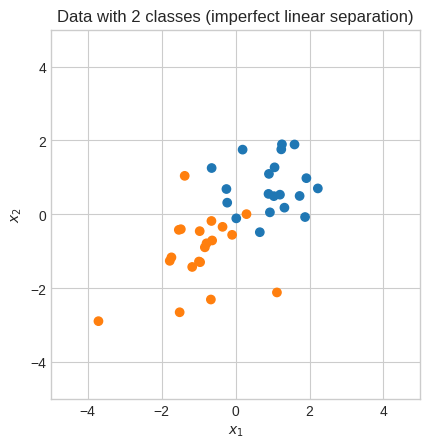

In [17]:
rng = np.random.default_rng(1)
group_1_centroid = [-1, -1]
group_2_centroid = [1, 1]
X = np.r_[
    rng.standard_normal((20, 2)) + group_1_centroid,
    rng.standard_normal((20, 2)) + group_2_centroid,
]
y = np.array([-1] * 20 + [1] * 20)

plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"))
plt.gca().set_aspect("equal")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Data with 2 classes (imperfect linear separation)")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

Let's try the hard margin implementation.

In [18]:
hard_initial = np.random.uniform(0, 1, 3)
hard_cons = [
    {"type": "ineq", "fun": hard_constraint, "args": (X, y, i)}
    for i in range(X.shape[0])
]

hard_result = minimize(fun=hard_loss, x0=hard_initial, constraints=hard_cons)

if np.allclose(hard_initial, hard_result.x):
    raise ValueError("Initial values close to final estimates")

ValueError: Initial values close to final estimates

With this data the hard margin optimizer doesn't work.

We need to give it some slack.

Let's introduce the slack variables $\zeta_i$

$\begin{array}{l}
\min \limits_{w, b, \zeta} \cfrac{1}{2} w \cdot w \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 - \zeta_i \quad \forall i = 1, \dots, m
\end{array}$

This way we allow for violations of the constraint. More specifically $\zeta_i$ can take the following values:

$\zeta_i=0$: The point $x_i$ is correctly classified and outside the margin.

$0<\zeta_i \le 1$: The point $x_i$ is correctly classified *but* within the margin.

$\zeta_i>1$: The point $x_i$ is misclassified.

Thus, $\zeta_i$ is constrained to be non-negative:

$\begin{array}{l}
\min \limits_{w, b, \zeta} \cfrac{1}{2} w \cdot w \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 - \zeta_i \\
\quad \quad \quad \quad \quad \zeta_i \ge 0 \quad \forall i = 1, \dots, m
\end{array}$

The problem is that a large enough $\zeta_i$ defeats the purpose of the constraint.

We can then penalize solutions that have large values of $\zeta_i$. Namely, we can add an L1 regularization for $\zeta_i$ and a regularization parameter $C$.

$\begin{array}{l}
\min \limits_{w, b, \zeta} \cfrac{1}{2} w \cdot w + C\sum^m_i\zeta_i \\ 
\text{subject to} \quad y_i(w \cdot x_i + b) \ge 1 - \zeta_i \\ 
\quad \quad \quad \quad \quad \zeta_i \ge 0 \quad \forall i = 1, \dots, m
\end{array}$

$C$ provides a trade-off between maximizing the margin (prioritizing generalization) and minimizing misclassification.

In the extreme case where $C = 0$, the objective function to be maximized is the same as in the hard margin SVM.

However, there is effectively no constraint on classification accuracy, as the slack variables are free to get as large as needed.

With a large $C$, solutions with large $\zeta_i$ values are heavily penalized. This leads to a narrower margin and to over-fitting because fewer misclassification are allowed.

A small $C$ allows for a wider margin, but at the cost of permitting more misclassification.

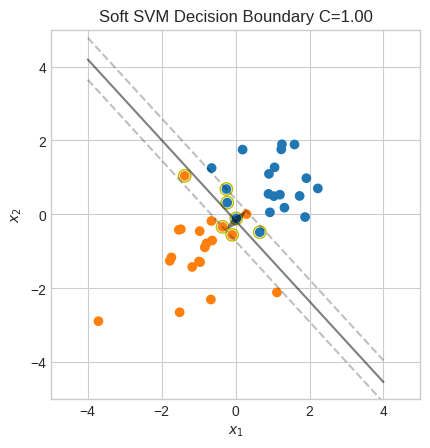

Accuracy: 98%


In [19]:
def soft_margin_svm(X, y, C):
    def soft_loss(params):
        w = params[: X.shape[1]]
        z = params[X.shape[1] + 1 :]
        return 0.5 * np.dot(w, w) + C * np.sum(z)

    def soft_constraint(params, X, y, i):
        w = params[: X.shape[1]]
        b = params[X.shape[1]]
        zi = params[X.shape[1] + 1 + i]
        return y[i] * (np.dot(w, X[i]) + b) - 1 + zi

    soft_initial = np.random.uniform(0, 1, X.shape[1] + 1 + X.shape[0])
    soft_cons = [
        {"type": "ineq", "fun": soft_constraint, "args": (X, y, i)}
        for i in range(X.shape[0])
    ]
    bounds_w = [(None, None)] * X.shape[1]
    bounds_b = [(None, None)]
    bounds_z = [(0, None)] * X.shape[0]
    bounds = bounds_w + bounds_b + bounds_z

    soft_result = minimize(
        fun=soft_loss, x0=soft_initial, constraints=soft_cons, bounds=bounds
    )

    if np.allclose(soft_initial, soft_result.x):
        raise ValueError("Initial values close to final estimates")

    w = soft_result.x[: X.shape[1]]
    b = soft_result.x[X.shape[1]]
    z = soft_result.x[X.shape[1] + 1 :]
    # indices of within-margin zetas sorted by farthest to closest
    svz = np.argwhere((z > 1e-6) & (z <= 1)).squeeze()[
        np.argsort(z[(z > 1e-6) & (z <= 1)])
    ]
    zX = X[svz]
    # within margin support vectors farthest from decision boundary (one per class)
    sv = np.vstack((zX[y[svz] > 0][0], zX[y[svz] < 0][0]))

    # plot data
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y == -1, "tab:orange", "tab:blue"))
    # plot decision boundary
    x1 = np.linspace(-4, 4, 100)
    plt.plot(x1, (-w[0] * x1 - b) / w[1], color="k", alpha=0.5)
    # plot parallels thru support vectors
    plt.plot(
        x1, parallel_thru_point(x1, w, sv[0]), color="k", linestyle="dashed", alpha=0.25
    )
    plt.plot(
        x1, parallel_thru_point(x1, w, sv[1]), color="k", linestyle="dashed", alpha=0.25
    )
    # highlight support vectors
    plt.scatter(
        zX[:, 0],
        zX[:, 1],
        s=80,
        facecolors="none",
        edgecolors="y",
        color="y",
    )
    # plot margin
    Q = np.array([0, decision_boundary(0, b=b, w=w)])
    proj_svp = (np.dot(sv[0] - Q, w) / np.linalg.norm(w)) * (w / np.linalg.norm(w))
    proj_svn = (np.dot(sv[1] - Q, w) / np.linalg.norm(w)) * (w / np.linalg.norm(w))
    plt.quiver(
        [Q[0], Q[0]],
        [Q[1], Q[1]],
        [proj_svp[0], proj_svn[0]],
        [proj_svp[1], proj_svn[1]],
        angles="xy",
        scale=1,
        scale_units="xy",
        color="k",
        alpha=0.5,
    )

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"Soft SVM Decision Boundary C={C:.2f}")
    plt.gca().set_aspect("equal")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.show()

    print(f"Accuracy: {np.mean(np.sign(X @ w + b) == y):.0%}")


soft_margin_svm(X, y, C=1)

Let's try a smaller value for $C$.

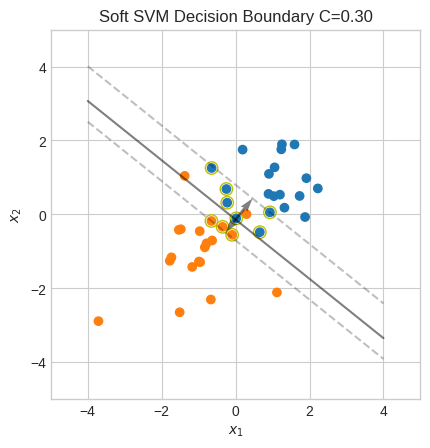

Accuracy: 95%


In [20]:
soft_margin_svm(X, y, C=0.3)